# In this notebook I will:
* Go through and remove reviews that only have advertisements? (NOT AT THIS TIME)
* Tokenize, lemmatize, remove stop words, and remove instances of words that only show up once that aren't special (words that indicate a condition, medication, side effect, or caregiver role)
* Rejoin processed review into a string for BOW analysis

In [1]:
import pandas as pd
import numpy as np
import glob

# Haven't decided whether I like nltk or spacy better yet
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet#, stopwords
#stops = stopwords.words('english')
import spacy
from spacy.tokenizer import Tokenizer
import en_core_web_lg
nlp = en_core_web_lg.load()

# Magical gensim module
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

# A method to process text in nltk:
# https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

# same process in spacy
# https://spacy.io/usage/linguistic-features

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# https://stackoverflow.com/questions/13928155/spell-checker-for-python/48280566
from autocorrect import Speller
spell = Speller(lang='en')

In [5]:
# Adjusting stop words in spacy to not lose a bunch of negatives for the sentiment analysis
# for word in [u'nor',u'none',u'not',u'alone',u'no',u'never',u'cannot',u'always']:
#     nlp.vocab[word].is_stop = False
# nlp.vocab[u'thing'].is_stop = True
tokenizer = Tokenizer(nlp.vocab)

# Working on processing text data

In [6]:
def get_wordnet_pos(treebank_tag):
    # https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
#     elif treebank_tag.startswith('NN'):
#         return wordnet.ADJ # Considering ADJ_SET to be same as ADJ
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def check_PoS(word):
    return get_wordnet_pos(nltk.pos_tag([word])[0][1])

def useful_synonyms(word):
    # Finding PoS of word
    to_pos = check_PoS(word)
    
    # Finding all synonyms in all the parts of speech
    words = []
    syns = wordnet.synsets(word)

    # Chopping down to most common versions of words...this works for side effects more than words like 'cat'
    if len(syns) >= 2:
        synList = syns[:2]
    else:
        synList = syns
    #     if len(syns)%2 and (len(syns) != 1):
#         synList = syns[:len(syns)//2]
#     else:
#         synList = syns[:len(syns)//2+1]

    # Finding all the forms of a word
    for syn in synList:
        for l in syn.lemmas():
            form = l.derivationally_related_forms()
            words.append(l.name())
            for f in form:
                words.append(f.name())
                
    # Getting all the unique words that match the desired part of speech
    words = list(np.unique(words))
    pos = nltk.pos_tag(words)
    return_words = [word.replace('_',' ') for word, word_pos in pos if get_wordnet_pos(word_pos)==to_pos]

    # Getting around weirdness with somehow dropping PoS for original word if matches to_pos (e.g., with weight)
    if get_wordnet_pos(nltk.pos_tag([word])[0][1]) == to_pos and word not in return_words: return_words.append(word)
        
    return return_words

In [7]:
# Magic tokenizer thing
def spacyTokenizer(s: str)-> list:
    doc = tokenizer(s.lower().strip())
    tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha and token.lemma_ != '-PRON-':
            tokens.append(token.lemma_)
        
    return tokens

In [8]:
def parseRevnew(file):
    sideEff = pd.read_csv(file, sep='$')['Comment']
    clean_SEs = [spacyTokenizer(SE) for SE in sideEff]

#     ignore = [SE for SE in clean_SEs if len(SE) <= 2]
#     consider = [SE for SE in clean_SEs if len(SE) > 2]
    
#     # Testing effect of just adding in more language to work with
#     new_consider = []
#     for chunk in consider:
#         extended = []
#         for w in chunk:
#             extended += [s for s in useful_synonyms(w) if s.find('_') == -1]
#         new_consider.append(extended)
    
    return clean_SEs#consider, ignore

def parseSEnew(file):
    sideEff = np.genfromtxt(file, delimiter='$', dtype=str)
    clean_SEs = [[spell(word) for word in spacyTokenizer(SE)] for SE in sideEff]

#     ignore = [SE for SE in clean_SEs if len(SE) <= 2]
#     consider = [SE for SE in clean_SEs if len(SE) > 2]
    
#     # Testing effect of just adding in more language to work with
#     new_consider = []
#     for chunk in consider:
#         extended = []
#         for w in chunk:
#             extended += [s for s in useful_synonyms(w) if s.find('_') == -1]
#         new_consider.append(extended)
    
    return clean_SEs#consider, ignore

In [9]:
# https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
def genDictandDocMatrix(cleaned_text):
    dictionary = corpora.Dictionary(cleaned_text)
    matrix = [dictionary.doc2bow(doc) for doc in cleaned_text]
    return dictionary, matrix

def formatLSAresult(topics:list)->list:
    for topic in topics:
        title = "Topic {:g}: \n".format(topic[0])
        term_cluster = [term.strip().split('*')[1][1:-1] for term in topic[1].split('+')]
        term_weight = [term.strip().split('*')[0] for term in topic[1].split('+')]

        print(title, ', '.join(term_cluster),'\n',', '.join(term_weight))
        
def produceLSA(n_topics, cleanText, n_word_report=10):
    dictionary, matrix = genDictandDocMatrix(cleanText)
    lsamodel = LsiModel(matrix, num_topics=n_topics, id2word=dictionary)
    result = lsamodel.print_topics(num_topics=n_topics, num_words=n_word_report)

    return result, lsamodel

def produceLDA(n_topics, cleanText, n_word_report=10):
    dictionary, matrix = genDictandDocMatrix(cleanText)
    ldamodel = LdaModel(matrix, num_topics=n_topics, id2word=dictionary)
    result = ldamodel.print_topics(num_topics=n_topics, num_words=n_word_report)

    return result, ldamodel

In [10]:
#listSideEff, list_ignored = parseSEnew('moddedSideEffects/Anxiety_SideEffects_denormed.csv')
reviews = parseRevnew('ProcessedReviews/Depression/Bupropion_Depression_parsed_reviews.csv')
listSEs = parseSEnew('moddedSideEffects/Depression_SideEffects_denormed.csv')

#result, model = produceLSA(10, reviews)

#formatLSAresult(result)

In [11]:
BagOSE = ' '.join([' '.join(SE) for SE in listSEs])

In [12]:
tfidf_vectr = TfidfVectorizer()
corpus = [' '.join(rev) for rev in reviews]
X = tfidf_vectr.fit_transform(corpus)
# tfidf_vectr.get_feature_names()

<1981x4072 sparse matrix of type '<class 'numpy.float64'>'
	with 40102 stored elements in Compressed Sparse Row format>

In [13]:
features = np.array(tfidf_vectr.get_feature_names())

In [23]:
found = [(f, i) for i,f in enumerate(features) if BagOSE.lower().find(' '+f+' ') != -1]
found = dict(found)
word_found = [f for f in found]
#ind_found = [i for i, f in found]

In [24]:
# TFIDF_found = X.toarray().T[np.array(ind_found)].T
# TFIDF_found.shape

# test = np.vstack([X.toarray()[:,ind] for ind in ind_found]).T
# print(test.sum(axis=1))
# # zeros mean word appears in every review...something off about that---> NO, NO INSTANCE OF THAT WORD PRESENT

In [25]:
more_words_found = (' '.join([' '.join(useful_synonyms(word)) for word in word_found])).split(' ')
syns_mwf = [(found[word],useful_synonyms(word)) for word in found]

# NEED TO GET INDICES FOR WORDS FOUND IN SYNS_MWF, USE IN SCORING STEP

In [26]:
wordsNotFound = [f for f in tfidf_vectr.get_feature_names() if f not in word_found]
from spacy.vocab import Vocab
allWords = tfidf_vectr.get_feature_names() #more_words_found + wordsNotFound
vocab = Vocab(strings=allWords)

for word in allWords:
    if word in wordsNotFound:
        vocab[word].is_stop = True
    else:
        vocab[word].is_stop = False
        
SETokenizer = Tokenizer(vocab)
 
def SECleaner(s: str):
    tokenized = SETokenizer(s)
    tokens = []
    for token in tokenized:
        if not token.is_stop:
            tokens.append(token.lemma_)
        
    return list(set(tokens))
#bagOFound = spacyTokenizer(' '.join([' '.join(mwf) for mwf in more_words_found]))

In [27]:
test = [rev for rev in corpus if SECleaner(rev)]
clean_results = [SECleaner(rev) for rev in corpus]

In [54]:
scoreDict = {}
overall_score = X.toarray()
mayhaps = dict([(word,overall_score[:,found[word]]) for word in found])
word_found = np.array(word_found)

for SE in listSEs:
    if SE:
        key = ' '.join(SE)
        scoreDict[key] = []
        for i,result in enumerate(clean_results):
            score = 0
            for word in set(result):
                if len(word) > 1:
                    TFIDF_score = mayhaps[word][i]

                    # I can't explain why this is true right now, but I will later
                    if TFIDF_score: 
                        score += (word in SE)*TFIDF_score
                            #print(TFIDF_score, word)
            scoreDict[key].append(score)

In [55]:
scoreDict

{'abdominal stomach pain': [0.0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0.15059015240652204,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.3109826757393186,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0.0,
  0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.3718555907839328,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.19208098478746005,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.19389662841339608,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0.0,
  0.0,
  0,
  0.0,
  0,
  0,
  0.2925907026696954,
  0.0,
  0

In [50]:
newtest = np.vstack([test[:,found[word]] for word in found]).T

In [53]:
len(listSEs), test.shape

(102, (1981, 4072))

abnormal orgasm problem ejaculation delay ['sexual', 'feel', 'delay', 'orgasm']
abnormal orgasm problem ejaculation delay ['problem']
abnormal orgasm problem ejaculation delay ['problem']
anxiety ['anxiety']
anxiety ['anxiety']
blindness blur vision decrease ['vision', 'blur']
blindness blur vision decrease ['vision', 'blur', 'vomit']
blindness blur vision decrease ['vision', 'blur']
blindness blur vision decrease ['decrease', 'feel', 'body', 'have', 'vision', 'blur', 'get', 'headache']
blindness blur vision decrease ['problem', 'vision', 'blur']
bloat fullness excess air gas stomach intestine ['gas']
body ache pain ['long', 'body', 'feel', 'muscle', 'ache', 'sleep']
body ache pain ['body', 'muscle', 'ache', 'severe', 'pain']
taste sense loss ['weight', 'loss']
night sweat ['diarrhea', 'stomach', 'feel', 'night', 'sweat', 'severe']
ring buzz noise ear ['ring', 'ear']
ring buzz noise ear ['ring', 'ear']
ring buzz noise ear ['ring', 'ear', 'weight', 'sleep', 'gain']
ring buzz noise ear [

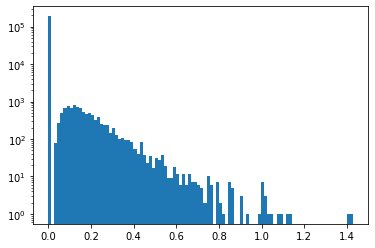

In [57]:
scores = []
for key in scoreDict: 
    for ind in range(len(scoreDict[key])):
        scores.append(scoreDict[key][ind])
        if scoreDict[key][ind] > 0.7:
            print(key, clean_results[ind])
        
plt.hist(scores, bins=100)
plt.yscale('log')

# The old way, which may return one day

In [ ]:
# Initializing the count vectorizer
vectorizer = CountVectorizer()

# Parsing side effects
def parseSideEffects_basic(file):
    # Loading in the file I curated
    sideEff = np.genfromtxt(file, delimiter='$', dtype=str)

    cleanedSEs = []
    uniqueness = []
    for SE in sideEff:
        if len(SE.strip().split(' ')) == 1:
            cleanedSEs.append(' '.join(list(set(getSynonyms(SE.strip().lower())))))
        else:
            cleanedSEs.append(' '.join(list(set(spacyTokenizer(SE)))))
        uniqueness.append([quantify_uniqueness(word) for word in spacyTokenizer(cleanedSEs[-1])])
    
    return cleanedSEs, uniqueness

def parseSideEffects_advanced(file):
    sideEff = np.genfromtxt(file, delimiter='$', dtype=str)
    sideEffectBlocks = {}
    for SE in sideEff:
        SEsplit = spacyTokenizer(SE)
        syns = []
        for word in SEsplit:
            convword = convert_word_plus_synonyms(word)
            syns.append(convword)
        sideEffectBlocks[SE] = syns
    return sideEffectBlocks

def parseReviewSentences_basic(file):
    reviews = pd.read_csv(file, sep='$')['Comment']
    
    cleanedRevs = [[' '.join(spacyTokenizer(sent)) for sent in rev.split('.')] for rev in reviews]
    return cleanedRevs

def findSideEffects_advanced(seFile, revFile):
    # Parsing side effects and reviews
    cleanedSEs = parseSideEffects_advanced(seFile)
    cleanedRevs = parseReviewSentences_basic(revFile)
    
    tracer = {}
    for i, rev in enumerate(cleanedRevs):
        tracer[i] = {}
        for j, cSE in enumerate(cleanedSEs):
            tracer[i][cSE] = np.zeros(len(cleanedSEs[cSE]))
            for k,wordSyns in enumerate(cleanedSEs[cSE]):
                if wordSyns:
                    vectorizer.vocabulary = wordSyns
                    X = vectorizer.fit_transform(rev).toarray()
                    result = (X > 0).sum() > 0
                    tracer[i][cSE][k] += result
    
    return tracer, cleanedSEs.keys(), cleanedRevs
    
def findSideEffects_basic(seFile, revFile):
    # Parsing side effects and reviews
    cleanedSEs, uniqSEs = parseSideEffects_basic(seFile)
    cleanedRevs = parseReviewSentences_basic(revFile)
    
    
    # For each sentence in each review
    tracer = {}
    for i,rev in enumerate(cleanedRevs):
        tracer[i] = {}
        for j,cSE in enumerate(cleanedSEs):
            concern = cSE.strip().split(' ')
            vectorizer.vocabulary = concern
            X = vectorizer.fit_transform(rev).toarray()
            result = (X*np.array(uniqSEs[j])[-1,None]).sum(axis=1)
            tracer[i][cSE] = result
            
    return tracer, cleanedSEs, cleanedRevs

In [ ]:
findings, SEs, Revs = findSideEffects_advanced('SideEffects/ADHD_SideEffects_denormed.csv',
                                           'ProcessedReviews/ADHD/Bupropion_ADHD_parsed_reviews.csv')

In [ ]:
for key in findings:
     for j in findings[key]:
            if findings[key][j].sum() > (len(findings[key][j])//2):
                print(Revs[key],'\n', j, '\n\n')

In [ ]:
# for i in findings:
#     for j in findings[i]:
#         if findings[i][j].sum() > 0.25: print(findings[i][j].sum(), j, '\n', Revs[i], '\n\n')
        
scores = []
revs = {}
for i in findings:
    revs['. '.join(Revs[i])] = []
    for j in findings[i]:
        score = findings[i][j].sum()/len(j.split(' '))**2
        scores.append(score)
        if score > 0.03: revs['. '.join(Revs[i])].append(j)
        
plt.hist(scores, bins=100)
plt.yscale('log')

In [ ]:
for rev in revs:
    if revs[rev]:
        print(rev, '\n', revs[rev], '\n\n')

In [ ]:
getSynonyms('sleepiness')

# Example of classical sentiment analysis

In [ ]:
# Working on sentiment analysis
# Starting source: https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python
# Other source: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

def comment_features(comment):
    document = list(nltk.FreqDist(w for w in spacyTokenizer(comment)))
    document_words = set(document)
    
    features = {}
    for word in document:
        features['contains({})'.format(word)] = (word in document_words)
    return features

def dichotomize_satisfaction(score):
    if score > 3:
        return 'positive'
    else:
        return 'negative'

featuresets = [(comment_features(comment),dichotomize_satisfaction(sat)) for comment, sat in zip(parsedDF['Comment'], parsedDF['Effectiveness'])] 
classifier = nltk.NaiveBayesClassifier.train(featuresets)
classifier.show_most_informative_features(20)